In [3]:
import sys
assert sys.version_info >= (3, 5)

import sklearn
assert sklearn.__version__ >= "0.20"

import numpy as np
import os
import warnings

import mlflow
import mlflow.sklearn

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [4]:
import os
import tarfile
import urllib.request

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [5]:
fetch_housing_data()

In [6]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [7]:
mlflow server --backend-store-uri sqlite:///mlflow.db --default-artifact-root ./mlruns --host 0.0.0.0 --port 5000

SyntaxError: invalid syntax (2550408040.py, line 1)

In [8]:
import sqlite3
print(sqlite3.sqlite_version)

3.45.3


In [9]:
remote_server_url="http://0.0.0.0:5000"
mlflow.set_tracking_url(remote_server_url)

AttributeError: module 'mlflow' has no attribute 'set_tracking_url'

In [17]:
os.environ['MLFLOW_TRACKING_URI'] = 'http://127.0.0.1:5000'

In [18]:
print(os.getenv('MLFLOW_TRACKING_URI'))

http://127.0.0.1:5000


In [19]:
exp_name="HousePricePrediction"
mlflow.set_experiment(exp_name)

2024/07/01 21:51:26 INFO mlflow.tracking.fluent: Experiment with name 'HousePricePrediction' does not exist. Creating a new experiment.


<Experiment: artifact_location='/mnt/c/Users/hp/Desktop/mlruns/mlruns/1', creation_time=1719850886233, experiment_id='1', last_update_time=1719850886233, lifecycle_stage='active', name='HousePricePrediction', tags={}>

In [22]:
from scipy.stats import randint
from six.moves import urllib
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    StratifiedShuffleSplit,
    train_test_split,
)
from sklearn.tree import DecisionTreeRegressor
    


In [23]:
fetch_housing_data()
housing = load_housing_data()

In [24]:
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)
housing["income_cat"] = pd.cut(
    housing["median_income"],
    bins=[0.0, 1.5, 3.0, 4.5, 6.0, np.inf],
    labels=[1, 2, 3, 4, 5],
)

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [25]:
def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

# Dropping income category from sets
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

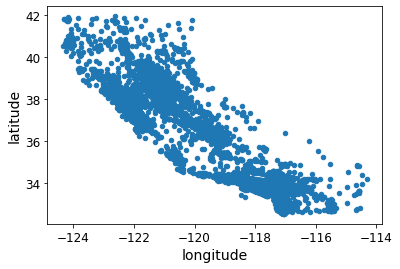

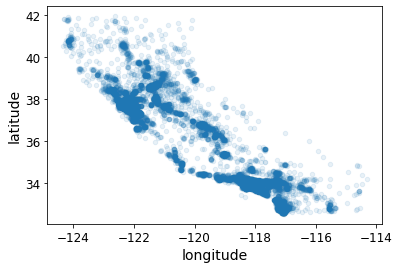

In [27]:
# Preparing data for training
housing = strat_train_set.copy()
housing.plot(kind="scatter", x="longitude", y="latitude")
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)



In [29]:
total_bedrooms = housing["total_bedrooms"]
total_rooms = housing["total_rooms"]
population = housing["population"]
households = housing["households"]
housing["rooms_per_household"] = total_rooms / households
housing["bedrooms_per_room"] = total_bedrooms / total_rooms
housing["population_per_household"] = population / households

In [30]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

# Imputing missing values
imputer = SimpleImputer(strategy="median")
housing_num = housing.drop("ocean_proximity", axis=1)
imputer.fit(housing_num)
X = imputer.transform(housing_num)
housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing.index)

total_rooms_tr = housing_tr["total_rooms"]
households_tr = housing_tr["households"]
total_bedrooms_tr = housing_tr["total_bedrooms"]
population_tr = housing_tr["population"]

housing_tr["rooms_per_household"] = total_rooms_tr / households_tr
housing_tr["bedrooms_per_room"] = total_bedrooms_tr / total_rooms_tr
housing_tr["population_per_household"] = population_tr / households_tr

In [31]:
housing_cat = housing[["ocean_proximity"]]
house_prepared = housing_tr.join(pd.get_dummies(housing_cat, drop_first=True))

In [36]:
with mlflow.start_run():
    mlflow.log_param("model_type", "LinearRegression")
    
    lin_reg = LinearRegression()
    lin_reg.fit(house_prepared, housing_labels)
    housing_predictions = lin_reg.predict(house_prepared)
    
    lin_rmse = np.sqrt(mean_squared_error(housing_labels, housing_predictions))
    lin_mae = mean_absolute_error(housing_labels, housing_predictions)
    
    mlflow.log_metric("RMSE", lin_rmse)
    mlflow.log_metric("MAE", lin_mae)
    
    # Logging the model itself as an artifact
    mlflow.sklearn.log_model(lin_reg, "linear_regression_model")
    
    print("Linear Regression - RMSE:", lin_rmse)
    print("Linear Regression - MAE:", lin_mae)

# Training a Decision Tree Regressor
with mlflow.start_run():
    mlflow.log_param("model_type", "DecisionTreeRegressor")
    
    tree_reg = DecisionTreeRegressor(random_state=42)
    tree_reg.fit(house_prepared, housing_labels)
    housing_predictions = tree_reg.predict(house_prepared)
    
    tree_rmse = np.sqrt(mean_squared_error(housing_labels, housing_predictions))
    
    mlflow.log_metric("RMSE", tree_rmse)
    
    # Logging the model itself as an artifact
    mlflow.sklearn.log_model(tree_reg, "decision_tree_regressor_model")
    
    print("Decision Tree Regressor - RMSE:", tree_rmse)

# Training a Random Forest Regressor with RandomizedSearchCV
param_distribs = {
    "n_estimators": randint(low=1, high=200),
    "max_features": randint(low=1, high=8),
}

forest_reg = RandomForestRegressor(random_state=42)




Linear Regression - RMSE: 68628.19819848923
Linear Regression - MAE: 49439.89599001875
Decision Tree Regressor - RMSE: 0.0
